**10 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge**

**데이터 전처리**

In [33]:
from sklearn.linear_model import Ridge , LogisticRegression
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
import pandas as pd

mercari_df= pd.read_csv('/content/mercari_train.tsv',sep='\t')
print(mercari_df.shape)
mercari_df.head()

(23184, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & Parts,Razer,52.0,0,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,"Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!"
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm] each. Stand about a foot high. They are being sold as a pair. Any questions please ask. Free shipping. Just got out of storage
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [34]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23184 entries, 0 to 23183
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   train_id           23184 non-null  int64  
 1   name               23184 non-null  object 
 2   item_condition_id  23184 non-null  int64  
 3   category_name      23069 non-null  object 
 4   brand_name         13245 non-null  object 
 5   price              23184 non-null  float64
 6   shipping           23184 non-null  int64  
 7   item_description   23184 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 1.4+ MB
None


<ipython-input-35-853c1516af29>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_df,kde=False)


<Axes: xlabel='price'>

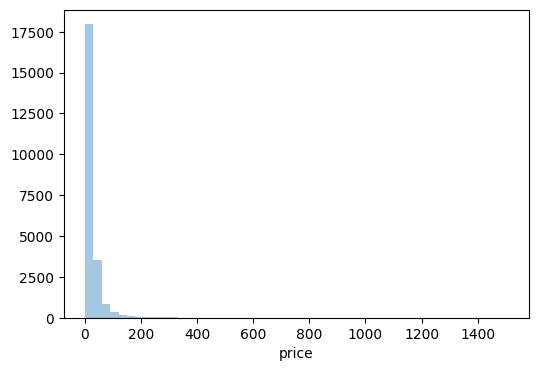

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df,kde=False)

<ipython-input-36-c747d56c8794>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_df,kde=False)


<Axes: xlabel='price'>

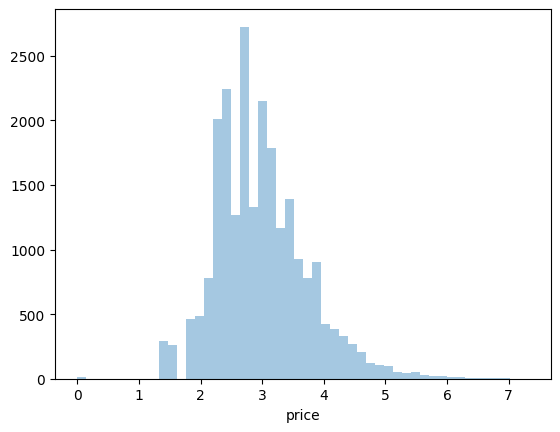

In [36]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df,kde=False)

-정규분포를 이룬다

-다음은 로그 값 변경

In [37]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [38]:
print('Shipping 값 유형:\n',mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n',mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 shipping
0    12797
1    10387
Name: count, dtype: int64
item_condition_id 값 유형:
 item_condition_id
1    10062
3     6756
2     5814
4      513
5       39
Name: count, dtype: int64


-Shipping 칼럼은 배송비 유무, 값 비교적 균일

In [39]:
boolean_cond= mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

1302

In [45]:
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')

# 각 컬럼별로 Null값 건수 확인. 모두 0가 나와야 합니다.
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

**피처 인코딩과 피처 벡터화**
 - 레이블 또는 원-핫 인코딩 수행하거나 피처 벡터화로 변환

In [46]:
print('brand name 의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

brand name 의 유형 건수 : 1103
brand name sample 5건 : 
 brand_name
Other_Null           9939
PINK                  872
Nike                  826
Victoria's Secret     725
LuLaRoe               466
Name: count, dtype: int64


In [47]:
print('name 의 종류 갯수 :', mercari_df['name'].nunique())
print('name sample 10건 : \n', mercari_df['name'][:10])

name 의 종류 갯수 : 22561
name sample 10건 : 
 0       MLB Cincinnati Reds T Shirt Size XL
1          Razer BlackWidow Chroma Keyboard
2                            AVA-VIV Blouse
3                     Leather Horse Statues
4                      24K GOLD plated rose
5          Bundled items requested for Ruie
6        Acacia pacific tides santorini top
7      Girls cheer and tumbling bundle of 7
8                     Girls Nike Pro shorts
9    Porcelain clown doll checker pants VTG
Name: name, dtype: object


In [48]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 개수
print('item_description 평균 문자열 개수:',mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 개수: 145.88988095238096


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

- TF-IDF 변환

In [49]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description 에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range= (1,3) , stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:',X_name.shape)
print('item_description vectorization shape:',X_descp.shape)

name vectorization shape: (23184, 12127)
item_description vectorization shape: (23184, 50000)


In [50]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name= LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [51]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand_shape:(23184, 1103), X_item_cond_id shape:(23184, 5)
X_shipping shape:(23184, 1), X_cat_dae shape:(23184, 11)
X_cat_jung shape:(23184, 109), X_cat_so shape:(23184, 573)


-피터 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트를 hstack()을 이용해 모두 결합

In [52]:
from  scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
            X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# 사이파이 sparse 모듈의 hstack 함수를 이용하여 앞에서 인코딩과 Vectorization을 수행한 데이터 셋을 모두 결합.
X_features_sparse= hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 셋이 메모리를 많이 차지하므로 사용 용도가 끝났으면 바로 메모리에서 삭제.
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (23184, 63929)


8

**릿지 회귀 모델 구축 및 평가**

In [53]:
def rmsle(y , y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test , preds):

    # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요.
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)

    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [54]:
import gc
from  scipy.sparse import hstack

def model_train_predict(model,matrix_list):
    # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
    X= hstack(matrix_list).tocsr()

    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'],
                                                      test_size=0.2, random_state=156)

    # 모델 학습 및 예측
    model.fit(X_train , y_train)
    preds = model.predict(X_test)

    del X , X_train , X_test , y_train
    gc.collect()

    return preds , y_test

In [55]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.5690951611902513
Item Description을 포함한 rmsle 값: 0.5495921368966962


- Item Description 포함했을 때 rmsle 값 많이 감소
- Itm Description 영향이 중요함

**LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가**

In [56]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.627500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82199
[LightGBM] [Info] Number of data points in the train set: 18547, number of used features: 3896
[LightGBM] [Info] Start training from score 2.978241
LightGBM rmsle 값: 0.6276197121409441


In [57]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.5445096967163229
